Macro Evaluation

In [122]:
import json
import jsonlines

In [5]:
def load_metric_log(experiment):
    with open('raw_output/' + experiment + '_metric_log.json') as f:
        metric_log = json.load(f)
    return metric_log

In [7]:
cr_metric_log = load_metric_log('gpt2_cr')
eg_metric_log = load_metric_log('gpt2_eg')
cr_eg_metric_log = load_metric_log('gpt2_cr_eg')

In [20]:
def select_epoch(metric_log, best=True, epoch=None, multitask=False, metric=None):
    if not best:
        assert isinstance(epoch, int), "Please provide an int epoch number, when not selecting the best epoch"
        assert 0 <= epoch < len(metric_log), "Epoch number is too small or too large"
        return {f'epoch_{epoch}':metric_log[f'epoch_{epoch}']}
    
    if not metric:
        metric = 'val_total_loss' if multitask else 'val_loss'
    minimize = False
    if 'loss' in metric:
        minimize = True
    best_epoch = 'epoch_0'
    assert metric in metric_log[best_epoch], "Metric is invalid. Consider checking if model is multitask"
    for epoch_key, epoch_metrics in metric_log.items():
        if minimize and epoch_metrics[metric] < metric_log[best_epoch][metric]:
            best_epoch = epoch_key
            continue
        if not minimize and epoch_metrics[metric] > metric_log[best_epoch][metric]:
            best_epoch = epoch_key
    return {best_epoch:metric_log[best_epoch]}

In [19]:
cr_best_epoch, cr_3epochs = select_epoch(cr_metric_log), select_epoch(cr_metric_log, best=False, epoch=2)
eg_best_epoch, eg_10epochs = select_epoch(eg_metric_log), select_epoch(eg_metric_log, best=False, epoch=9)
cr_eg_best_epoch = select_epoch(cr_eg_metric_log, multitask=True)
cr_eg_5epochs = select_epoch(cr_eg_metric_log, best=False, multitask=True, epoch=4)
cr_best_accuracy_epoch = select_epoch(cr_metric_log, metric='accuracy')
cr_eg_best_accuracy_epoch = select_epoch(cr_eg_metric_log, metric='accuracy')

In [59]:
def view(metrics):
    for epoch, log in metrics.items():
        print(epoch, [f'{metric}: {value:.4f}' for metric, value in log.items() if 'train' not in metric])

In [61]:
# Selected epochs reported by paper
print('CR:')
view(cr_3epochs)
print('CR-EG:')
view(cr_eg_5epochs)
print('EG:')
view(eg_10epochs)

CR:
epoch_2 ['val_loss: 2.0488', 'accuracy: 0.6656']
CR-EG:
epoch_4 ['val_total_loss: 4.8051', 'val_cr_loss: 4.0053', 'val_eg_loss: 12.0040', 'accuracy: 0.6993', 'bleu1: 0.5610', 'bleu2: 0.3544', 'bleu3: 0.2569', 'bleu4: 0.2154', 'avg_bleu: 0.3469', 'rouge1: 0.3444', 'rouge2: 0.1165', 'rougel: 0.3350', 'perplexity: 6.7933']
EG:
epoch_9 ['val_loss: 6.3349', 'bleu1: 0.4957', 'bleu2: 0.3035', 'bleu3: 0.2041', 'bleu4: 0.1630', 'avg_bleu: 0.2916', 'rouge1: 0.3266', 'rouge2: 0.1028', 'rougel: 0.3126', 'perplexity: 7.2673']


In [68]:
# CR: best epochs
print('Best loss:')
view(cr_best_epoch)
print('Best accuracy:')
view(cr_best_accuracy_epoch) 

Best loss:
epoch_5 ['val_loss: 2.0053', 'accuracy: 0.6820']
Best accuracy:
epoch_9 ['val_loss: 2.1330', 'accuracy: 0.7017']


In [67]:
# CR-EG: best epochs
print('Best loss:')
view(cr_eg_best_epoch)
print('Best accuracy:')
view(cr_eg_best_accuracy_epoch) 

Best loss:
epoch_4 ['val_total_loss: 4.8051', 'val_cr_loss: 4.0053', 'val_eg_loss: 12.0040', 'accuracy: 0.6993', 'bleu1: 0.5610', 'bleu2: 0.3544', 'bleu3: 0.2569', 'bleu4: 0.2154', 'avg_bleu: 0.3469', 'rouge1: 0.3444', 'rouge2: 0.1165', 'rougel: 0.3350', 'perplexity: 6.7933']
Best accuracy:
epoch_8 ['val_total_loss: 5.3411', 'val_cr_loss: 4.6100', 'val_eg_loss: 11.9217', 'accuracy: 0.7149', 'bleu1: 0.5581', 'bleu2: 0.3512', 'bleu3: 0.2562', 'bleu4: 0.2156', 'avg_bleu: 0.3453', 'rouge1: 0.3462', 'rouge2: 0.1132', 'rougel: 0.3357', 'perplexity: 6.6798']


In [69]:
# EG: best epoch
view(eg_best_epoch)

epoch_6 ['val_loss: 5.9345', 'bleu1: 0.5379', 'bleu2: 0.3250', 'bleu3: 0.2227', 'bleu4: 0.1804', 'avg_bleu: 0.3165', 'rouge1: 0.3259', 'rouge2: 0.0982', 'rougel: 0.3137', 'perplexity: 6.8181']


Micro Evaluation

In [188]:
from matplotlib import pyplot as plt
import seaborn as sns

In [157]:
import pandas as pd

In [84]:
# load micro evaluation results
def load_cr_micro(filename):
    with open('micro_evaluation/' + filename, 'r') as f:
        lines = f.readlines()
        return [int(line) for line in lines]

In [87]:
# load macro evaluation results
def load_eg_micro(filename):
    with open('micro_evaluation/' + filename, 'r') as f:
        return json.load(f)

In [91]:
single_cr = load_cr_micro('gpt2_cr_epoch_9_micro_CR.csv')
multi_cr = load_cr_micro('gpt2_cr_eg_epoch_8_micro_CR.csv')

In [139]:
single_eg = load_eg_micro('gpt2_eg_epoch_6_micro_EG.json')
multi_eg = load_eg_micro('gpt2_cr_eg_epoch_8_micro_EG.json')
eg_metric_list = single_eg[0].keys()

In [140]:
# m0 is single, m1 is multi
m0_cr = single_cr
m1_cr = multi_cr
m0_eg = None
m1_eg = multi_eg

In [143]:
m0_right_m1_wrong = dict(indices=[])
m0_wrong_m1_right = dict(indices=[])
both_right = dict(indices=[])
both_wrong = dict(indices=[])
for i in range(len(m1_cr)):
    if m0_cr[i] == 1:
        if m1_cr[i] == 1:
            both_right['indices'].append(i)
        else:
            m0_right_m1_wrong['indices'].append(i)
    else:
        if m1_cr[i] == 1:
            m0_wrong_m1_right['indices'].append(i)
        else:
            both_wrong['indices'].append(i)
        

In [144]:
def compute_eg_aggregate_metrics(bucket, m0_eg, m1_eg):
    for metric in eg_metric_list:
        m0_values, m1_values = [], []
        for i in bucket['indices']:
            if m0_eg:
                m0_values.append(m0_eg[i][metric])
            m1_values.append(m1_eg[i][metric])
        if m0_eg:
            bucket[metric] = dict(
                m0=sum(m0_values)/len(m0_values) if len(m0_values) > 0 else 0,
                m1=sum(m1_values)/len(m1_values) if len(m1_values) > 0 else 0
            )
        else:
            bucket[metric] = sum(m1_values)/len(m1_values) if len(m1_values) > 0 else 0


In [145]:
compute_eg_aggregate_metrics(m0_right_m1_wrong, m0_eg, m1_eg)
compute_eg_aggregate_metrics(m0_wrong_m1_right, m0_eg, m1_eg)
compute_eg_aggregate_metrics(both_right, m0_eg, m1_eg)
compute_eg_aggregate_metrics(both_wrong, m0_eg, m1_eg)

In [146]:
def view_eg_aggregate_metrics(bucket):
    for metric in eg_metric_list:
        print(metric, bucket[metric])


In [147]:
print("m0 wrong m1 right")
view_eg_aggregate_metrics(m0_wrong_m1_right)
print("m0 right m1 wrong")
view_eg_aggregate_metrics(m0_right_m1_wrong)
print("both right")
view_eg_aggregate_metrics(both_right)
print("both wrong")
view_eg_aggregate_metrics(both_wrong)

m0 wrong m1 right
avg_bleu 0.29032130606855094
rouge1 0.2472919086333722
rouge2 0.08458712696517572
rougel 0.23992154864106102
avg_rouge 0.19060019474653617
cos_sim 0.6138139215275282
m0 right m1 wrong
avg_bleu 0.3069072789564377
rouge1 0.26775409359679037
rouge2 0.08250270328922012
rougel 0.26217024236687175
avg_rouge 0.20414234641762727
cos_sim 0.6036745635060112
both right
avg_bleu 0.30467817745823883
rouge1 0.26281306955737543
rouge2 0.08732734204958924
rougel 0.25570548912718466
avg_rouge 0.2019486335780507
cos_sim 0.624154872264537
both wrong
avg_bleu 0.28807247115062345
rouge1 0.24400039525917758
rouge2 0.07304396748190654
rougel 0.2353702308620343
avg_rouge 0.18413819786770627
cos_sim 0.6025205422978002


In [129]:
fi = jsonlines.open('../data/dev_full_augmented.jsonl', 'r')
ask_for_cause = [1 if line['ask-for'] == 'cause' else 0 for line in fi]
fi = jsonlines.open('../data/dev_full_augmented.jsonl', 'r')
hypo_sim = [line['hypotheses_cosine_sim'] for line in fi]

In [134]:
def cut_cr_by_task(bucket):
    cause_list = []
    hypo_sim_list = []
    for i in bucket['indices']:
        cause_list.append(ask_for_cause[i])
        hypo_sim_list.append(hypo_sim[i])
    bucket['ask_for_cause_ratio'] = sum(cause_list) / len(cause_list) if len(cause_list) > 0 else 0
    bucket['avg_hypo_sim'] = sum(hypo_sim_list) / len(hypo_sim_list) if len(hypo_sim_list) > 0 else 0
    print('ask_for_cause_ratio', bucket['ask_for_cause_ratio'])
    print('hypo_sim', bucket['avg_hypo_sim'])

In [148]:
print('m0_right_m1_wrong')
cut_cr_by_task(m0_right_m1_wrong)
print('m0_wrong_m1_right')
cut_cr_by_task(m0_wrong_m1_right)
print('both_right')
cut_cr_by_task(both_right)
print('both_wrong')
cut_cr_by_task(both_wrong)

m0_right_m1_wrong
ask_for_cause_ratio 0.5449438202247191
hypo_sim 0.34923573026140586
m0_wrong_m1_right
ask_for_cause_ratio 0.5121951219512195
hypo_sim 0.3627962773665786
both_right
ask_for_cause_ratio 0.5190548780487805
hypo_sim 0.26916532526136105
both_wrong
ask_for_cause_ratio 0.46604215456674475
hypo_sim 0.3774465502739232


In [150]:
# For CR-EG model, check correlation between CR task metrics and EG task metrics
right = dict(indices=[])
wrong = dict(indices=[])
for i in range(len(m1_cr)):
    if m1_cr[i] == 1:
        right['indices'].append(i)
    else:
        wrong['indices'].append(i)
        


In [151]:
compute_eg_aggregate_metrics(right, None, m1_eg)
compute_eg_aggregate_metrics(wrong, None, m1_eg)

In [152]:
print("right")
view_eg_aggregate_metrics(right)
print("wrong")
view_eg_aggregate_metrics(wrong)

right
avg_bleu 0.30273805970287565
rouge1 0.26071561537845583
rouge2 0.0869570427138577
rougel 0.25357252419662724
avg_rouge 0.20041506076298102
cos_sim 0.6227574464892656
wrong
avg_bleu 0.2936139517943175
rouge1 0.25098908667090486
rouge2 0.07582686826488484
rougel 0.2432551929246144
avg_rouge 0.19002371595346856
cos_sim 0.6028600725045136


In [193]:
cr_eg_df = pd.DataFrame(data=m1_eg)
cr_eg_df['correct'] = m1_cr
cr_eg_df['ask_for_cause'] = ask_for_cause
cr_eg_df['hypo_sim'] = hypo_sim

In [184]:
min(hypo_sim)

-0.09644091129302979

Text(0.5, 9.444444444444438, "Hypotheses' cosine similarity")

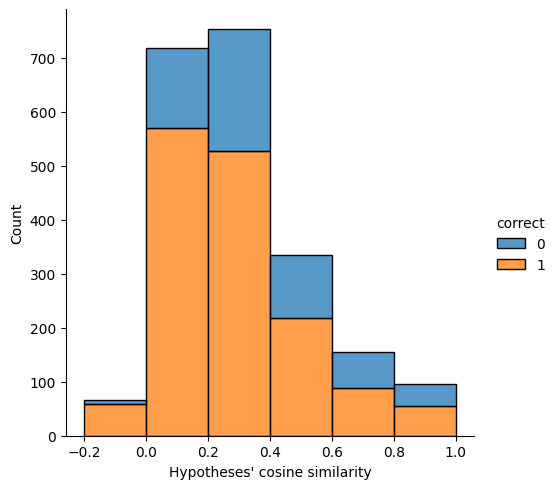

In [194]:
sns.displot(data=cr_eg_df, x='hypo_sim', hue='correct', multiple='stack', bins=[-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.xlabel("Hypotheses' cosine similarity")

In [195]:
cr_eg_df.head()

,avg_bleu,rouge1,rouge2,rougel,avg_rouge,cos_sim,correct,ask_for_cause,hypo_sim
0,0.368134,0.428571,0.000,0.285714,0.238095,0.827844,0,1,0.398462
1,0.372037,0.235294,0.125,0.235294,0.198529,0.628947,1,0,0.310161
2,0.196922,0.000000,0.000,0.000000,0.000000,0.608897,1,1,0.621964
3,0.205334,0.333333,0.000,0.333333,0.222222,0.795344,1,1,0.341030
4,0.189313,0.222222,0.125,0.222222,0.189815,0.838283,1,1,0.137618


In [196]:
cr_eg_df.corr()

,avg_bleu,rouge1,rouge2,rougel,avg_rouge,cos_sim,correct,ask_for_cause,hypo_sim
avg_bleu,1.000000,0.815827,0.665500,0.812003,0.812772,0.671610,0.019955,-0.017886,-0.001544
rouge1,0.815827,1.000000,0.760931,0.992075,0.979106,0.609272,0.018344,-0.005131,0.004634
rouge2,0.665500,0.760931,1.000000,0.771091,0.873485,0.409612,0.027723,0.000762,0.001015
rougel,0.812003,0.992075,0.771091,1.000000,0.982006,0.605090,0.019803,-0.008222,0.001493
avg_rouge,0.812772,0.979106,0.873485,0.982006,1.000000,0.581092,0.022566,-0.004849,0.002637
cos_sim,0.671610,0.609272,0.409612,0.605090,0.581092,1.000000,0.039139,-0.002814,0.026346
correct,0.019955,0.018344,0.027723,0.019803,0.022566,0.039139,1.000000,0.026074,-0.177581
ask_for_cause,-0.017886,-0.005131,0.000762,-0.008222,-0.004849,-0.002814,0.026074,1.000000,-0.031006
hypo_sim,-0.001544,0.004634,0.001015,0.001493,0.002637,0.026346,-0.177581,-0.031006,1.000000


In [199]:
hypo_sim_index_09, hypo_sim_09 = [], []
for i, sim in enumerate(hypo_sim):
    if sim > 0.9 and m1_cr[i] == 0 and m0_cr[i] == 0:
        hypo_sim_index_09.append(i)
        hypo_sim_09.append(sim)
print(hypo_sim_index_09)

[866, 1009, 1244, 1252, 1350, 1499, 1790, 1895]


In [200]:
hypo_sim_index_0406, hypo_sim_0406 = [], []
for i, sim in enumerate(hypo_sim):
    if 0.4 < sim < 0.6 and m1_cr[i] == 0 and m0_cr[i] == 0:
        hypo_sim_index_0406.append(i)
        hypo_sim_0406.append(sim)
print(hypo_sim_index_0406)

[62, 88, 90, 114, 118, 150, 156, 159, 173, 211, 215, 219, 233, 235, 280, 331, 333, 336, 340, 353, 369, 391, 392, 422, 447, 516, 551, 560, 565, 583, 588, 649, 745, 763, 867, 879, 897, 899, 908, 942, 966, 1001, 1003, 1031, 1048, 1067, 1106, 1130, 1148, 1180, 1181, 1187, 1193, 1231, 1273, 1305, 1316, 1337, 1339, 1366, 1482, 1512, 1545, 1561, 1587, 1599, 1646, 1675, 1712, 1743, 1745, 1754, 1805, 1811, 1871, 1882, 1891, 1904, 1907, 1920, 1962, 1986, 1991, 1994, 2098, 2108]


In [202]:
hypo_sim_index_0002, hypo_sim_0002 = [], []
for i, sim in enumerate(hypo_sim):
    if 0 < sim < 0.2 and m1_cr[i] == 0 and m0_cr[i] == 0:
        hypo_sim_index_0002.append(i)
        hypo_sim_0002.append(sim)
print(hypo_sim_index_0002)

[32, 35, 38, 54, 57, 74, 128, 147, 164, 176, 177, 194, 214, 221, 228, 238, 258, 263, 267, 285, 289, 346, 348, 359, 401, 433, 441, 442, 455, 479, 523, 549, 566, 599, 629, 652, 655, 672, 675, 722, 725, 799, 814, 834, 857, 878, 903, 913, 918, 919, 955, 1015, 1018, 1036, 1040, 1056, 1083, 1089, 1093, 1101, 1133, 1164, 1172, 1188, 1206, 1227, 1233, 1234, 1248, 1257, 1282, 1373, 1376, 1410, 1488, 1537, 1553, 1605, 1660, 1686, 1688, 1701, 1704, 1788, 1812, 1814, 1830, 1834, 1840, 1851, 1859, 1863, 1880, 1930, 1949, 1952, 1990, 2011, 2022, 2057, 2088, 2097]


In [203]:
print(m0_cr[39], m1_cr[39])

0 1


In [209]:
m0_wrong_m1_right['indices'][:5]


[33, 39, 48, 53, 69]

In [207]:
m1_cos_sim = [e['cos_sim'] for e in m1_eg]
sum(m1_cos_sim)/len(m1_cos_sim)

0.6170845382608137

In [208]:
m2_eg = single_eg
m2_cos_sim = [e['cos_sim'] for e in m2_eg]
sum(m2_cos_sim)/len(m2_cos_sim)

0.5228403264502064